<a href="https://colab.research.google.com/github/ameervalki/Pandas-EDA/blob/master/Sentiment_Analysis_News_Processing_and_Understanding_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data retrieval

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,"Uber to fire 3,700 employees worldwide, CEO no...",Ride-hailing company Uber on Wednesday said it...,technology
1,"Airbnb fires 1,900 employees making 25% of its...","Airbnb, the US-based startup that connects tra...",technology
2,Grimes explains the name of her and Elon Musk'...,A day after Tesla CEO Elon Musk said his baby ...,technology
3,Amazon VP who quit over staff firings says Goo...,The Amazon VP who quit over the firm's decisio...,technology
4,Indians evacuated from abroad will have to dow...,"Indians stranded abroad, who will be brought b...",technology
5,Wishing good vibes for all in second half 2020...,"Tesla's billionaire CEO Elon Musk, who recentl...",technology
6,It's my fault: Samsung heir apologises over co...,Samsung Group heir Jay Y Lee has apologised fo...,technology
7,Billionaire Elon Musk qualifies for $706 milli...,Tesla CEO Elon Musk has qualified for stock op...,technology
8,French hacker says Aarogya Setu putting 'priva...,French hacker Robert Baptiste on Tuesday alert...,technology
9,Google India's website to inform people about ...,Google India launched a new website on Wednesd...,technology


In [4]:
news_df.news_category.value_counts()

sports        25
world         25
technology    25
Name: news_category, dtype: int64

In [9]:
!pip install nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
!pip install contractions

     |████████████████████████████████| 317kB 3.6MB/s 
     |████████████████████████████████| 245kB 15.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81692 sha256=9a75cff2be92d0bcdcd7e0e47fe505209dd5bb81d24a065640e1e53be0040062
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


# Text Wrangling and Pre-processing

In [0]:

import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import contractions
import unicodedata


tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Remove HTML tags

In [11]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

## Remove accented characters

In [14]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expand contractions

In [22]:
import contractions
def expand_contractions(text):
    
    
        
    expanded_text = contractions.fix(text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'you all can not expand contractions I would think'

## Remove special characters

In [23]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

## Text lemmatization

In [37]:
import spacy
nlp = spacy.load('en_core_web_sm', parse = True, tag=True, entity=True)


def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

## Text stemming

In [26]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Remove stopwords

In [27]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Building a text normalizer

In [0]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize news articles

In [0]:
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

In [41]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'airbnb fire employee make global workforce airbnb us base startup connect traveller place stay fire employee comprise around global workforce employee note employee co founder ceo brian chesky call coronavirus pandemic harrowing crisis lifetime truly sorry please know not fault chesky tell fire employee',
 'full_text': 'Airbnb fires 1,900 employees making 25% of its global workforce. Airbnb, the US-based startup that connects travellers with places to stay, is firing 1,900 employees comprising around 25% of its global workforce of 7,500 employees. In a note to employees, Co-founder and CEO Brian Chesky called coronavirus pandemic "the most harrowing crisis of our lifetime". "I am truly sorry. Please know this is not your fault," Chesky told fired employees.'}

# Save the news articles

In [0]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Tagging Parts of Speech

In [80]:
news_df = pd.read_csv('news.csv')
news_df

,news_headline,news_article,news_category,full_text,clean_text
0,"Uber to fire 3,700 employees worldwide, CEO no...",Ride-hailing company Uber on Wednesday said it...,technology,"Uber to fire 3,700 employees worldwide, CEO no...",uber fire employee worldwide ceo not take base...
1,"Airbnb fires 1,900 employees making 25% of its...","Airbnb, the US-based startup that connects tra...",technology,"Airbnb fires 1,900 employees making 25% of its...",airbnb fire employee make global workforce air...
2,Grimes explains the name of her and Elon Musk'...,A day after Tesla CEO Elon Musk said his baby ...,technology,Grimes explains the name of her and Elon Musk'...,grime explain name elon musk first child x day...
3,Amazon VP who quit over staff firings says Goo...,The Amazon VP who quit over the firm's decisio...,technology,Amazon VP who quit over staff firings says Goo...,amazon vp quit staff firing say google huawei ...
4,Indians evacuated from abroad will have to dow...,"Indians stranded abroad, who will be brought b...",technology,Indians evacuated from abroad will have to dow...,indians evacuate abroad download aarogya setu ...
...,...,...,...,...,...
70,Hong Kong will never be calm unless violent pr...,China's Hong Kong affairs office on Wednesday ...,world,Hong Kong will never be calm unless violent pr...,hong kong never calm unless violent protester ...
71,Skies in Niger's capital turn red during sand ...,"Skies in Niamey, the capital city of Niger, tu...",world,Skies in Niger's capital turn red during sand ...,sky niger capital turn red sand storm video su...
72,Afghan forces deactivate joint ISIS and Haqqan...,"Afghanistan's intelligence agency, National Di...",world,Afghan forces deactivate joint ISIS and Haqqan...,afghan force deactivate joint isis haqqani net...
73,Trump made 'stupid mistake' by exiting from nu...,"US President Donald Trump ""made a stupid mista...",world,Trump made 'stupid mistake' by exiting from nu...,trump make stupid mistake exit nuclear deal ro...


In [0]:
news_df = news_df.drop(columns = ['news_headline','full_text'])


In [82]:
news_df

,news_article,news_category,clean_text
0,Ride-hailing company Uber on Wednesday said it...,technology,uber fire employee worldwide ceo not take base...
1,"Airbnb, the US-based startup that connects tra...",technology,airbnb fire employee make global workforce air...
2,A day after Tesla CEO Elon Musk said his baby ...,technology,grime explain name elon musk first child x day...
3,The Amazon VP who quit over the firm's decisio...,technology,amazon vp quit staff firing say google huawei ...
4,"Indians stranded abroad, who will be brought b...",technology,indians evacuate abroad download aarogya setu ...
...,...,...,...
70,China's Hong Kong affairs office on Wednesday ...,world,hong kong never calm unless violent protester ...
71,"Skies in Niamey, the capital city of Niger, tu...",world,sky niger capital turn red sand storm video su...
72,"Afghanistan's intelligence agency, National Di...",world,afghan force deactivate joint isis haqqani net...
73,"US President Donald Trump ""made a stupid mista...",world,trump make stupid mistake exit nuclear deal ro...


In [84]:
corpus = news_df.iloc[:,2].values
corpus

array(['uber fire employee worldwide ceo not take base salary ride hail company uber wednesday say fire full time employee worldwide comprise around company total workforce uber ceo dara khosrowshahi make million base salary waive base salary remain year uber estimate incur approximately million relate severance termination benefit',
       'airbnb fire employee make global workforce airbnb us base startup connect traveller place stay fire employee comprise around global workforce employee note employee co founder ceo brian chesky call coronavirus pandemic harrowing crisis lifetime truly sorry please know not fault chesky tell fire employee',
       'grime explain name elon musk first child x day tesla ceo elon musk say baby boy call x musk girlfriend grime tweet explain meaning newborn name x refer unknown variable elven spelling ai love artificial intelligence say precursor sr sr favourite aircraft add',
       'amazon vp quit staff firing say google huawei contact amazon vp quit fir

In [85]:
!pip install afinn

# Emotion and Sentiment Analysis

In [0]:
from afinn import Afinn

af = Afinn()

In [0]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [88]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  2.36  6.793870 -13.0 -2.0  2.0  6.0  16.0
technology               25.0 -1.28  5.660683 -13.0 -6.0 -2.0  3.0  10.0
world                    25.0 -3.24  7.298858 -23.0 -7.0 -4.0  2.0  13.0

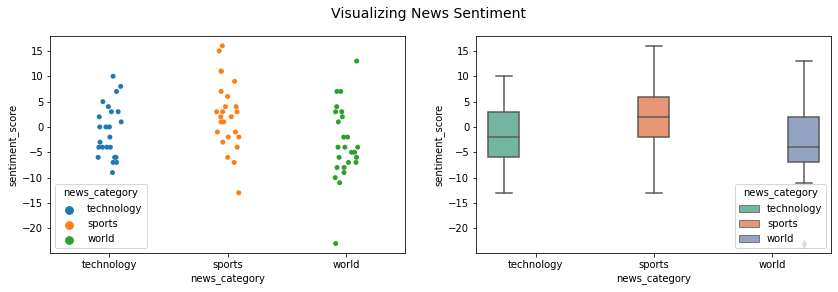

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


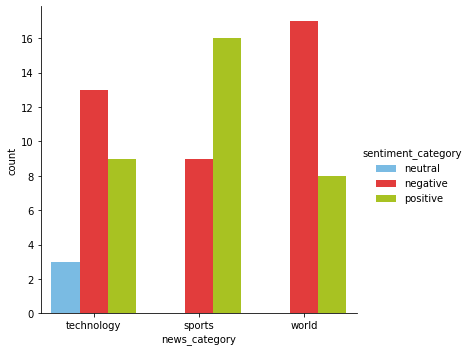

In [90]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [91]:
df

,news_category,sentiment_score,sentiment_category
0,technology,0.0,neutral
1,technology,-9.0,negative
2,technology,5.0,positive
3,technology,-6.0,negative
4,technology,-2.0,negative
...,...,...,...
70,world,-10.0,negative
71,world,3.0,positive
72,world,-8.0,negative
73,world,-8.0,negative


In [93]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 3)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -13)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Samsung Group heir Jay Y Lee has apologised for a corruption scandal, adding he won't hand over the management to his children. "This is my fault. I apologise. Samsung hasn't strictly complied with laws and ethics," he said. Lee was convicted in 2017 for bribing South Korea's ex-President to support a deal that would give him more ownership of Samsung.



Most Positive Tech News Article: Apple and Google have published sample user interface screenshots of how their exposure notification system could work. The samples showed how the apps will likely work when a user is diagnosed as COVID-19 positive. They also presented what an exposure notification regarding being exposed to someone with COVID-19 could look like.


In [95]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 13)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -23)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Bing Liu, a University of Pittsburgh professor was shot and killed in an apparent murder-suicide, police said. Authorities believe an unidentified second man, who was found dead in his car, shot and killed Liu in his home before returning to his car and killing himself. Liu was on the verge of making "very significant findings" about coronavirus, the university said.

Most Positive World News Article: New Zealand Prime Minister Jacinda Ardern said that the country's success in curbing coronavirus has given it a "safe haven advantage" to welcome investments. "We have positioned our economy to be able to rebuild ahead of many others globally," she added. Ardern further said that New Zealand offers a safe place for operations in both the health and business sense.


In [0]:
from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [97]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                     ...                     
                        count     mean       std  ...    50%    75%    max
news_category                                     ...                     
sports                   25.0  0.06628  0.212131  ...  0.073  0.183  0.500
technology               25.0 -0.01608  0.210870  ...  0.000  0.089  0.400
world                    25.0 -0.00544  0.239007  ...  0.055  0.106  0.401

[3 rows x 8 columns]

In [98]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,-0.408,negative
1,technology,-0.325,negative
2,technology,0.013,positive
3,technology,-0.200,negative
4,technology,0.089,positive


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


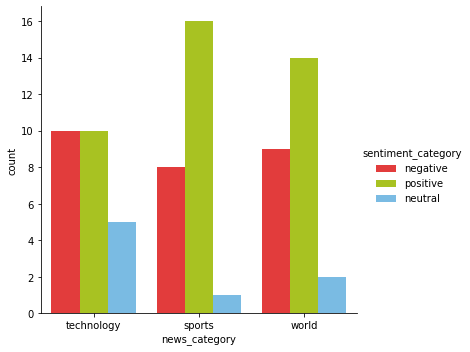

In [99]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [101]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.401)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.800)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: US President Donald Trump "made a stupid mistake by exiting from the nuclear deal", Iranian President Hassan Rouhani said. The US should lift all sanctions on Tehran and compensate for reimposition of sanctions if it wants to return to the deal, Rouhani added. Further, he said, "Iran will give a crushing response if the arms embargo on Tehran is extended."

Most Positive World News Article: New Zealand Prime Minister Jacinda Ardern said that the country's success in curbing coronavirus has given it a "safe haven advantage" to welcome investments. "We have positioned our economy to be able to rebuild ahead of many others globally," she added. Ardern further said that New Zealand offers a safe place for operations in both the health and business sense.


In [102]:
!pip install model_evaluation_utils

ERROR: Could not find a version that satisfies the requirement model_evaluation_utils (from versions: none)
ERROR: No matching distribution found for model_evaluation_utils


In [104]:
from sklearn.metrics import confusion_matrix as meu
meu(sentiment_category,sentiment_category_tb,['negative', 'neutral', 'positive'])

array([[21,  2, 16],
       [ 1,  2,  0],
       [ 5,  4, 24]])